Todo:
* Chart of account age. Show how many newbies - done
* Chart of account size -done
* Hide compromised accounts - done
* 6/10/23 Use SQL to check for active

In [2]:
cfile='users.txt'
country='Brits'

In [3]:
# Build a list of active users suitable for a Hive post
# Loads users from file users.txt. Lines starting with R are regions

from datetime import datetime, timedelta, date, timedelta
from beem import Hive
from beem.account import Account
from beem.amount import Amount
from beem.comment import Comment
from beem.exceptions import ContentDoesNotExistsException
from beem.instance import set_shared_blockchain_instance
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pyodbc
import pandas as pd
import sys

In [4]:
with open('pw.txt') as f:
    for l in f:
        uname, pw = l.split()

cnxn_str = ("Driver={ODBC Driver 18 for SQL Server};"
            "Server=vip.hivesql.io;"
            "Database=DBHive;"
            f"UID={uname};"
            f"PWD={pw};"
           "Encrypt=no")
cnxn = pyodbc.connect(cnxn_str)

In [5]:
#hive = Hive(node=['https://api.deathwing.me']) #'https://anyx.io'])#https://rpc.ausbit.dev','https://api.deathwing.me', 'https://api.hive.blog'])
#set_shared_blockchain_instance(hive)
stop = datetime.utcnow() - timedelta(days=31) # Checks last month
stopstr = stop.strftime('%Y-%m-%d')
fullstop = datetime.utcnow() - timedelta(days=365) # Checks last year
sqlfromdate = (date.today()-timedelta(days=365)).strftime('%Y-%m-%d')
sqlmonth = (date.today()-timedelta(days=31)).strftime('%Y-%m-%d')
#print(sqlfromdate)

In [6]:
hacked = []
#with open('steemengineteam_group.txt','r') as f:
#    for l in f:
#        hacked.append(l.strip())

In [7]:
def check_witness(user):
    global wits
    iswit = len(pd.read_sql(f"""select name, w.last_hbd_exchange_update
                from witnesses w
                where w.last_hbd_exchange_update > '{sqlmonth}'
                  and w.name='{user}'""", cnxn))
    if iswit:
        wits.append(f'@{user}')

In [8]:
def useractive(user):
    # Work back looking for last post/comment or vote
    #acc = Account(user)#, blockchain_instance=hive)
    voted = commented = activeyear = False
    vests = 0
    created = ''

    r = pd.read_sql(f"""select a.last_post, a.last_vote_time, a.vesting_shares, a.created
                from Accounts a
                where a.name='{user}'""", cnxn)
    for i, l in r.iterrows():
        activeyear = l['last_post'] > fullstop or l['last_vote_time'] > fullstop 
        voted = l['last_vote_time'] > stop
        commented = l['last_post'] > stop
        vests = l['vesting_shares']
        created = l['created']
        break    
    if False:
        for a in acc.history_reverse(stop=fullstop, only_ops=["vote", 
                                                      "comment"]):
            activeyear = True
            if a['timestamp'][:10] >= stopstr:
                if a["type"] == "vote":
                    voted = True
                if a["author"] == user:
                    if a["type"] == "comment":
                        commented = True
                        break # Don't need to check if they voted as well
            else:
                break
    return (voted, commented, activeyear, vests, created)

def useractivex(user, sql=True):
    # Work back looking for last post/comment or vote
    try:
        acc = Account(user)#, blockchain_instance=hive)
    except Exception as e:
        print(f'Failed at {user} with {e}')
        sys.exit()
        
    voted = commented = activeyear = False

    if not sql and not (voted or commented):
        activeyear = False
        for a in acc.history_reverse(stop=fullstop, only_ops=["vote", 
                                                      "comment"]):
            activeyear = True
            break

    if False:
        r = pd.read_sql(f"""select count(*) as count
                from Accounts a
                where a.name = '{user}'
                    and (a.last_vote_time  >= '{sqlfromdate}' or a.last_post  >= '{sqlfromdate}')
                    """, cnxn)
        for i, l in r.iterrows():
            activeyear = l['count'] > 0
            break

    if sql:
        r = pd.read_sql(f"""select a.last_vote_time, a.last_post
                from Accounts a
                where a.name = '{user}'
                    """, cnxn)
        for i, l in r.iterrows():
            #print(l['last_vote_time'], l['last_post'])
            activeyear = str(l['last_vote_time']) >= sqlfromdate or str(l['last_post']) >= sqlfromdate
            if str(l['last_post']) >= sqlmonth:
                commented = True
            elif str(l['last_vote_time']) >= sqlmonth:
                voted = True
            break

            
    if False and activeyear:
        for a in acc.history_reverse(stop=stop, only_ops=["vote", 
                                                          "comment"]):
            if a["type"] == "vote":
                voted = True
            if a["author"] == user:
                if a["type"] == "comment":
                    commented = True
                    break # Don't need to check if they voted as well

    return (voted, commented, activeyear)

In [9]:
def output_region(region, active, voting, inactive):
    if region != None:
        act, voter, inact = len(active), len(voting), len(inactive)
        print(f'## {region} ({act}/{voter}/{inact})')
        if region == 'Anonymous':
            print('Some people ask not to be listed, but they will still be counted')
            print()
        else:
            if act:
                print('Posting: @'+ (', @'.join(sorted(active))))
                print()
            if voter:
                print('Voting: @'+ (', @'.join(sorted(voting))))
                print()
            if inact:
                print('Inactive: @'+ (', @'.join(sorted(inactive))))
                print()

In [10]:
with open(cfile, 'r') as f:
    active = []
    inactive = []
    voting =[]
    newbie = []
    wits = []
    region = None
    now = datetime.utcnow() 
    total_active = 0
    fish = {'Redfish': 0, 'Minnow':0, 'Dolphin':0, 'Orca':0, 'Whale':0}
    age = {'1 Month':0, '2 Months':0, '3 Months':0, '3 Months+':0, '1 Year':0}
    for a in range(2, 10):
        age[f'{a} Years'] = 0
    for l in f:
        fields = l.split(',')
        if fields[0] == 'R':
            output_region(region, active, voting, inactive)
            total_active += len(active) # Will not count the last region, but exclude expats from total anyway
            region = fields[1].strip()
            active, voting, inactive = [], [], []
        else:
            # Witness check
            unames = []
            if '@' in l:
                unames.append(l.split()[0])
                l = l[l.find('@'):]
                unames += l.strip().replace('(', '').replace(')', '').replace('@', '').split()
            elif '(' in l:
                unames.append(l.split()[0])
            else:
                unames.append(l.strip())
            for uu in unames:
                check_witness(uu)
                
            name = dname = fields[0].strip()
            if '(' in name:
                dname = name
                name = name[:(name.find('(')-1)]
            if not name in hacked:
                voter, commenter, activeyear, vests, created = useractive(name)
                if commenter:
                    active.append(dname)
                elif voter:
                    voting.append(dname)
                elif activeyear: # Inactive
                    inactive.append(dname)
                if commenter or voter:
                    #acc = Account(name)
                    #hp = acc.balances['available'][2].amount_decimal
                    hp = vests
                    if hp > 1E9:
                        fish['Whale'] += 1
                    elif hp > 1E8:
                        fish['Orca'] += 1
                        #with open('orcas.txt','a') as orc:
                        #    orc.write(f'{name}\n')
                    elif hp > 1E7:
                        fish['Dolphin'] += 1
                    elif hp > 1E6:
                        fish['Minnow'] += 1
                    else:
                        fish['Redfish'] += 1

                    #for i in acc.get_account_history(0,1):
                    #    created = cr = datetime.strptime(i['timestamp'], '%Y-%m-%dT%H:%M:%S')
                    accage = (now - created).days
                    if accage > 365.25 * 9:
                        age['9 Years'] += 1
                    elif accage > 365.25 * 8:
                        age['8 Years'] += 1
                    elif accage > 365.25 * 7:
                        age['7 Years'] += 1
                    elif accage > 365.25 * 6:
                        age['6 Years'] += 1
                    elif accage > 365.25 * 5:
                        age['5 Years'] += 1
                    elif accage > 365.25 * 4:
                        age['4 Years'] += 1
                    elif accage > 365.25 * 3:
                        age['3 Years'] += 1
                    elif accage > 365.25 * 2:
                        age['2 Years'] += 1
                    elif accage > 365:
                        age['1 Year'] += 1
                    elif accage > 90:
                        age['3 Months+'] += 1
                    elif accage > 60:
                        age['3 Months'] += 1
                    elif accage > 30:
                        #with open('recent.txt','a') as orc:
                        #    orc.write(f'{name} 2 months\n')
                        age['2 Months'] += 1
                    else:
                        with open('recent.txt','a') as orc:
                            orc.write(f'{name} 1 month\n')
                        age['1 Month'] += 1
                    if accage <= 90:
                        newbie.append(dname)

    output_region(region, active, voting, inactive)
    print('## Totals')
    print(f'**Total active** {country}: {total_active}, Expats: {len(active)}')
    print('')
    
    if len(newbie):
        print('## Newbies')
        print('Please welcome the people who recently joined Hive:')
        print('@'+ (', @'.join(sorted(newbie))))
        print('')
    
    minnowhp = 607 #hive.vests_to_hp(1E6)
    print('# Charts')
    print(f"This shows the numbers in each category of the active and voting accounts. Level is based on 'VESTS' with Minnow equating to a million VESTS.")
    print()
    print('|Level|Number|Threshold|')
    print('|-|-|-|')
    for i,f in enumerate(fish):
        hp = f'{minnowhp:11.2f} HP' if i > 0 else ''
        print(f'|{f:8}|{fish[f]:4}|{hp}|')
        if i > 0:
            minnowhp *= 10
    print()
    print('This shows when people joined Hive. The last few months are shown separately to make any changes obvious.')
    print('|Age|Number|')
    print('|-|-|')
    for a in age:
        print(f'|{a}|{age[a]}|')
    
    if len(wits):
        print(f'''
# {country} Witnesses
Please support your local witnesses:''')
        print(', '.join(wits))

## London and the South East (41/39/42)
Posting: @adetorrent (London), @alonicus (Hampshire), @anna-newkey (Cambridgeshire @steve.and.anke), @assassyn (Reading), @audiohive-me (@riverstage), @basilmarples (Norwich), @benthomaswwd (Northampton @heartbeatonhive @benthomasuk @pulsation @pfsonhive), @bombaycrypto (London), @cezary-io, @chris-uk (Norwich), @daine-cherry, @davidthompson57 (West Sussex), @donatello, @dubble (London), @edenmichelle, @gillianpearce (Brighton), @lloyddavis (Guildford @steemcampuk @lloyd-social), @lovlygirl (London), @mcsamm (Milton Keynes), @mightyrocklee (Bedfordshire @heruvim1978 @heruvim78), @molometer (London @mopal), @nicklewis (Berkshire), @practicaleric (London), @purplesinger (Bedfordshire), @pvmihalache (Bedford), @queenoftheworld, @revisesociology, @risingstargame (@atomcollector @juxtamusic @jux), @samsmith1971, @sergiomendes (@thesassysergio), @spectrumecons, @stav (Norfolk), @steevc (Bedfordshire @tenkminnows @swing47 @theriverkicks), @stormkeepergu

{'Redfish': 111, 'Minnow': 83, 'Dolphin': 51, 'Orca': 19, 'Whale': 0}


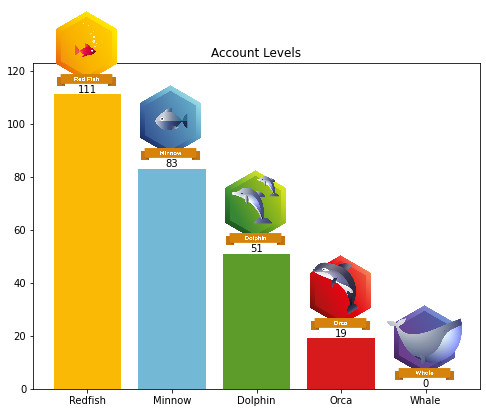

In [11]:
print(fish)
x_pos = range(len(fish))

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
color = ['#fab904','#73b8d4','#5d9b2a',
         '#d71b1c','#8c9be6']
plt.bar(x_pos, fish.values(), color=color)
plt.xticks(x_pos, fish.keys(), rotation=0)
plt.title('Account Levels')
ax.set_ylim(0,max(fish.values())+12)

shiftX = 0.52  
shiftY = 0.52  
arr_img = plt.imread("level1.png")
im = OffsetImage(arr_img, zoom=.15)
ab1 = AnnotationBbox(im, (x_pos[0]+shiftX,fish['Redfish']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

arr_img = plt.imread("level2.png")
im = OffsetImage(arr_img, zoom=.15)
ab2 = AnnotationBbox(im, (x_pos[1]+shiftX,fish['Minnow']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

arr_img = plt.imread("level3.png")
im = OffsetImage(arr_img, zoom=.15)
ab3 = AnnotationBbox(im, (x_pos[2]+shiftX,fish['Dolphin']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

arr_img = plt.imread("level4.png")
im = OffsetImage(arr_img, zoom=.15)
ab4 = AnnotationBbox(im, (x_pos[3]+shiftX,fish['Orca']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

arr_img = plt.imread("level5.png")
im = OffsetImage(arr_img, zoom=.15)
ab5 = AnnotationBbox(im, (x_pos[4]+shiftX,fish['Whale']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

ax.add_artist(ab1)
ax.add_artist(ab2)
ax.add_artist(ab3)
ax.add_artist(ab4)
ax.add_artist(ab5)

plt.text(x_pos[0],fish['Redfish'],s=fish.get('Redfish'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[1],fish['Minnow'],s=fish.get('Minnow'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[2],fish['Dolphin'],s=fish.get('Dolphin'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[3],fish['Orca'],s=fish.get('Orca'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[4],fish['Whale'],s=fish.get('Whale'),horizontalalignment='center',verticalalignment='bottom')

plt.savefig('fish.png')

{'1 Month': 1, '2 Months': 1, '3 Months': 1, '3 Months+': 3, '1 Year': 2, '2 Years': 6, '3 Years': 22, '4 Years': 32, '5 Years': 28, '6 Years': 14, '7 Years': 61, '8 Years': 66, '9 Years': 27}


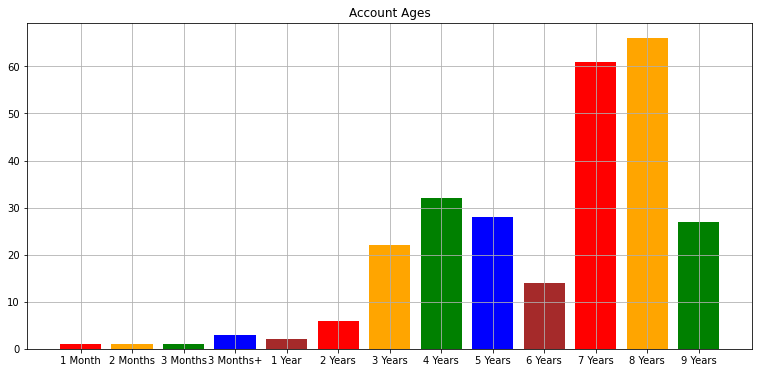

In [12]:
print(age)
fig, ax = plt.subplots()
fig.set_size_inches(13,6)
plt.bar(age.keys(), age.values(), color=['red', 'orange', 'green','blue','brown']);
plt.title('Account Ages')
ax.grid()